In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('milk.csv')
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,Good,Bad,High,Low,254.0,high
1,6.6,36,Bad,Good,Low,High,253.0,high
2,8.5,70,Good,Good,High,High,246.0,low
3,9.5,34,Good,Good,Low,High,255.0,low
4,6.6,37,Bad,Bad,Low,Low,255.0,medium


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1042 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1032 non-null   object 
 3   Odor        1059 non-null   object 
 4   Fat         1059 non-null   object 
 5   Turbidity   1059 non-null   object 
 6   Colour      1033 non-null   float64
 7   Grade       1059 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 66.3+ KB


In [4]:
df.isnull().sum()

pH            17
Temprature     0
Taste         27
Odor           0
Fat            0
Turbidity      0
Colour        26
Grade          0
dtype: int64

In [5]:
df.describe()

,pH,Temprature,Colour
count,1042.000000,1059.000000,1033.000000
mean,6.625624,44.226629,251.820910
std,1.401326,10.098364,4.321152
min,3.000000,34.000000,240.000000
25%,6.500000,38.000000,250.000000
50%,6.700000,41.000000,255.000000
75%,6.800000,45.000000,255.000000
max,9.500000,90.000000,255.000000


In [6]:
cat_col = df.select_dtypes(include=['object']).columns.tolist()

for i in cat_col:
    print(i)
    print(df[i].value_counts())
    print('-'*30)

Taste
Good    564
Bad     468
Name: Taste, dtype: int64
------------------------------
Odor
Bad     601
Good    458
Name: Odor, dtype: int64
------------------------------
Fat 
High    711
Low     348
Name: Fat , dtype: int64
------------------------------
Turbidity
Low     539
High    520
Name: Turbidity, dtype: int64
------------------------------
Grade
low       429
medium    374
high      256
Name: Grade, dtype: int64
------------------------------


## **Data Cleaning**

In [7]:
# rename column
df.rename({'Fat ': 'Fat'}, axis=1, inplace=True)

In [8]:
df.columns

Index(['pH', 'Temprature', 'Taste', 'Odor', 'Fat', 'Turbidity', 'Colour',
       'Grade'],
      dtype='object')

In [9]:
# target encoding
df.Grade.value_counts()

low       429
medium    374
high      256
Name: Grade, dtype: int64

In [10]:
df.Grade.replace({'low': 0, 'medium': 1, 'high': 2}, inplace=True)
df.Grade.value_counts()

0    429
1    374
2    256
Name: Grade, dtype: int64

In [11]:
# split
X = df.drop('Grade', axis=1)
y = df.Grade

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(741, 7)
(318, 7)
(741,)
(318,)


In [12]:
df_eda = pd.concat([X_train, y_train], axis=1)
df_eda.shape

(741, 8)

In [13]:
X_train_eda = X_train.copy()

## **EDA for Modeling**

In [14]:
X_train_eda.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
143,3.0,40,Good,Bad,Low,Low,255.0
576,6.6,40,Good,Bad,High,High,255.0
686,3.0,40,Good,Good,High,High,255.0
544,6.5,37,Bad,Bad,Low,Low,255.0
889,6.8,45,Good,Good,High,High,245.0


In [15]:
num_col = ['pH', 'Temprature', 'Colour']
cat_col = ['Taste', 'Odor', 'Fat', 'Turbidity']

**numerical preprocess**

In [16]:
X_train_eda[num_col]

,pH,Temprature,Colour
143,3.0,40,255.0
576,6.6,40,255.0
686,3.0,40,255.0
544,6.5,37,255.0
889,6.8,45,245.0
...,...,...,...
440,6.6,45,250.0
840,6.5,36,255.0
429,6.7,38,255.0
462,5.5,45,250.0


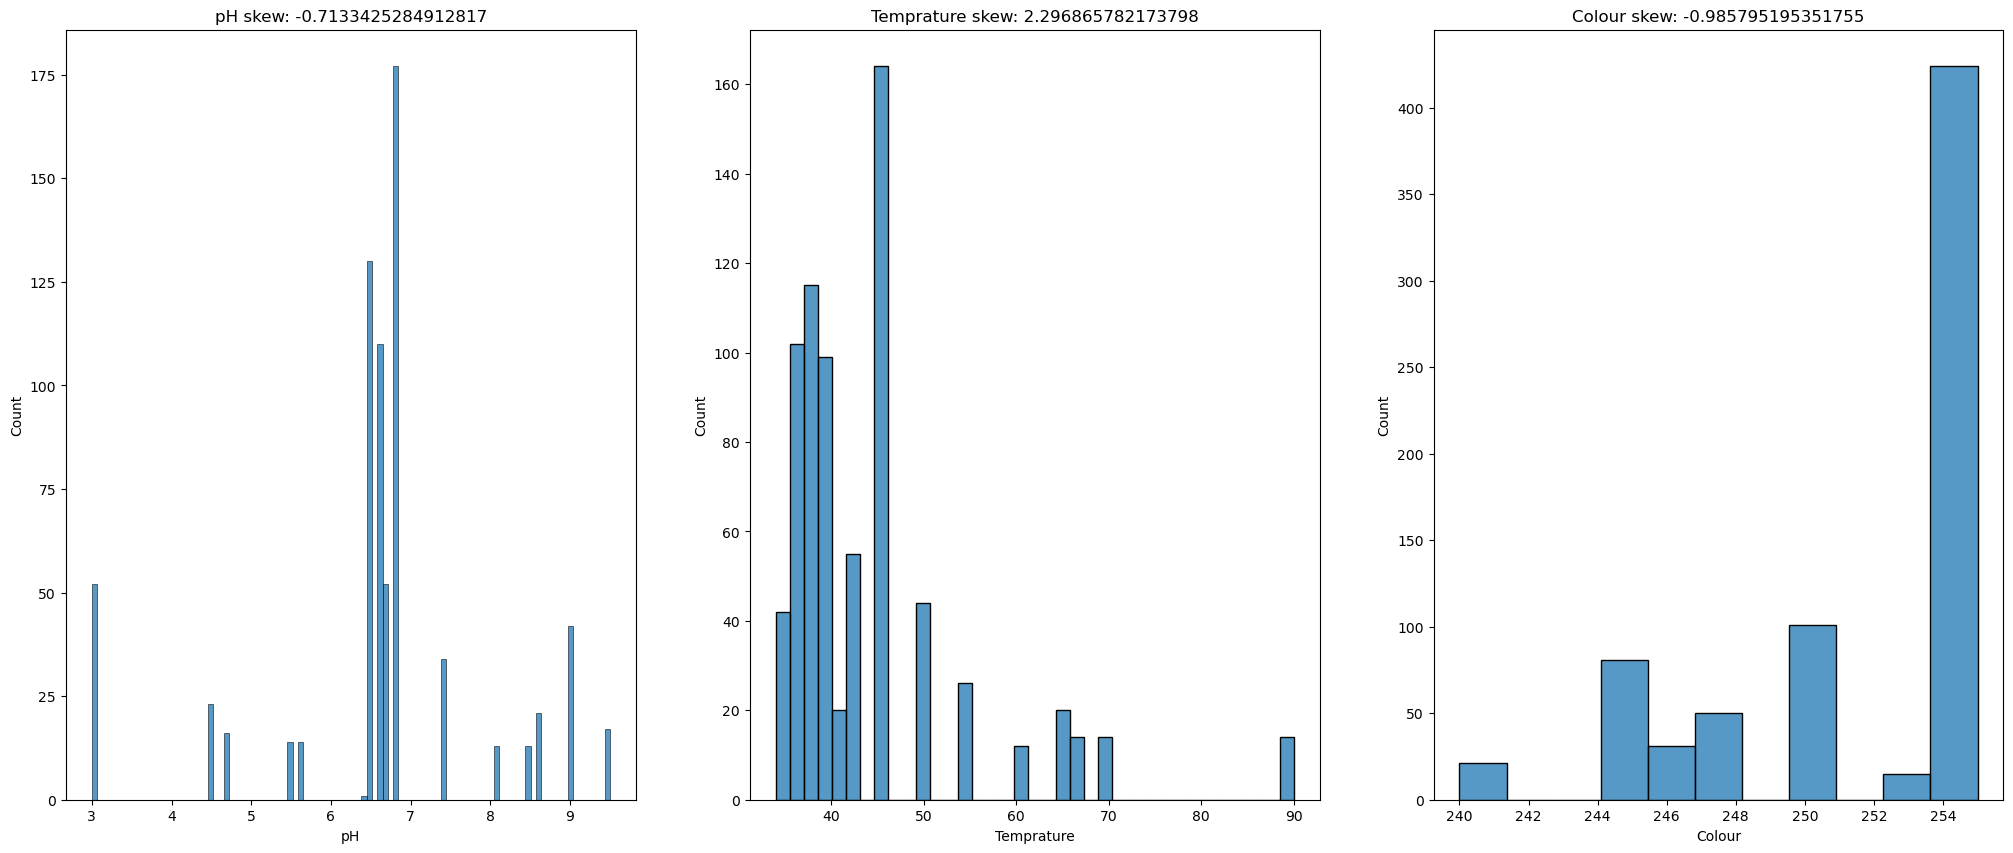

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=[25,10])
ax = ax.flatten()

for idx, col in enumerate(num_col):
    sns.histplot(X_train_eda[col], ax=ax[idx])
    ax[idx].set_title(f'{num_col[idx]} skew: {X_train_eda[col].skew()}')

In [18]:
# let's say we have normal distribution in pH, just for example
# outlier detection in pH
# gaussian
upper = X_train_eda['pH'].mean() + (3 * X_train_eda['pH'].std())
lower = X_train_eda['pH'].mean() - (3 * X_train_eda['pH'].std())

outlier = X_train_eda[(X_train_eda['pH'] <= lower) | (X_train_eda['pH'] >= upper)]

print('percentage: ', len(outlier)/X_train_eda.shape[0] * 100, '%')

percentage:  0.0 %


In [19]:
# outlier detection in Temperature
Q1 = X_train_eda['Temprature'].quantile(.25)
Q3 = X_train_eda['Temprature'].quantile(.75)

IQR = Q3 - Q1

upper = Q3 + (3*IQR)
lower = Q1 - (3*IQR)

outlier = X_train_eda[(X_train_eda['Temprature'] <= lower) | (X_train_eda['Temprature'] >= upper)]

print('percentage: ', len(outlier)/X_train_eda.shape[0] * 100, '%')
print('upper: ', upper)
print('lower: ', lower)

percentage:  5.668016194331984 %
upper:  66.0
lower:  17.0


In [20]:
# outlier detection in Colour
Q1 = X_train_eda['Colour'].quantile(.25)
Q3 = X_train_eda['Colour'].quantile(.75)

IQR = Q3 - Q1

upper = Q3 + (3*IQR)
lower = Q1 - (3*IQR)

outlier = X_train_eda[(X_train_eda['Colour'] <= lower) | (X_train_eda['Colour'] >= upper)]

print('percentage: ', len(outlier)/X_train_eda.shape[0] * 100, '%')

percentage:  0.0 %


outlier only exist in Temprature columns, using fold 3 IQR. will be handled using winsorizer transformer

In [21]:
wins = Winsorizer(capping_method='iqr', tail='both', fold=3,
                  variables=['Temprature'], missing_values='ignore')

X_train_eda = wins.fit_transform(X_train_eda)
X_train_eda.describe()

,pH,Temprature,Colour
count,729.000000,741.000000,723.000000
mean,6.593964,43.847503,251.788382
std,1.406321,8.431742,4.309466
min,3.000000,34.000000,240.000000
25%,6.500000,38.000000,248.000000
50%,6.700000,41.000000,255.000000
75%,6.800000,45.000000,255.000000
max,9.500000,66.000000,255.000000


**missing value handling**

In [22]:
X_train_eda[num_col].isnull().sum()

pH            12
Temprature     0
Colour        18
dtype: int64

missing value on numerical columns will be handled using median estimator from each columns

In [23]:
imp_num = SimpleImputer(strategy='median')

X_train_eda[num_col] = imp_num.fit_transform(X_train_eda[num_col])
X_train_eda[num_col].isnull().sum()

pH            0
Temprature    0
Colour        0
dtype: int64

In [24]:
imp_num.statistics_

array([  6.7,  41. , 255. ])

In [25]:
X_train_eda.describe()

,pH,Temprature,Colour
count,741.000000,741.000000,741.000000
mean,6.595682,43.847503,251.866397
std,1.394936,8.431742,4.285389
min,3.000000,34.000000,240.000000
25%,6.500000,38.000000,250.000000
50%,6.700000,41.000000,255.000000
75%,6.800000,45.000000,255.000000
max,9.500000,66.000000,255.000000


**scaling features numeric**

In [26]:
scaler = MinMaxScaler()

X_train_eda[num_col] = scaler.fit_transform(X_train_eda[num_col])
X_train_eda

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
143,0.000000,0.18750,Good,Bad,Low,Low,1.000000
576,0.553846,0.18750,Good,Bad,High,High,1.000000
686,0.000000,0.18750,Good,Good,High,High,1.000000
544,0.538462,0.09375,Bad,Bad,Low,Low,1.000000
889,0.584615,0.34375,Good,Good,High,High,0.333333
...,...,...,...,...,...,...,...
440,0.553846,0.34375,Bad,Bad,Low,High,0.666667
840,0.538462,0.06250,Bad,Bad,High,Low,1.000000
429,0.569231,0.12500,Good,Bad,High,Low,1.000000
462,0.384615,0.34375,Good,Bad,High,High,0.666667


**features engineering on categorical column**

In [27]:
X_train_eda.isnull().sum()

pH             0
Temprature     0
Taste         18
Odor           0
Fat            0
Turbidity      0
Colour         0
dtype: int64

In [28]:
# missing value handling
imp_cat = SimpleImputer(strategy='most_frequent')
X_train_eda[cat_col] = imp_cat.fit_transform(X_train_eda[cat_col])

imp_cat.statistics_

array(['Good', 'Bad', 'High', 'Low'], dtype=object)

In [29]:
X_train_eda.isnull().sum()

pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
dtype: int64

In [30]:
X_train_eda[['Taste', 'Odor', 'Fat']]

,Taste,Odor,Fat
143,Good,Bad,Low
576,Good,Bad,High
686,Good,Good,High
544,Bad,Bad,Low
889,Good,Good,High
...,...,...,...
440,Bad,Bad,Low
840,Bad,Bad,High
429,Good,Bad,High
462,Good,Bad,High


In [31]:
# encoding Taste, Odor, Fat -> ordinal
taste_cat = ['Bad', 'Good']
odor_cat = ['Bad', 'Good']
fat_cat = ['Low', 'High']

ord_enc = OrdinalEncoder(categories=[taste_cat, odor_cat, fat_cat])
cat_ord = pd.DataFrame(ord_enc.fit_transform(X_train_eda[['Taste', 'Odor', 'Fat']]))

cat_ord.columns = ['Taste_enc', 'Odor_enc', 'Fat_enc']
review = pd.concat([X_train_eda[['Taste', 'Odor', 'Fat']].reset_index(drop=True), cat_ord], axis=1)

review.sample(5)

,Taste,Odor,Fat,Taste_enc,Odor_enc,Fat_enc
179,Bad,Bad,High,0.0,0.0,1.0
402,Bad,Good,High,0.0,1.0,1.0
697,Bad,Good,Low,0.0,1.0,0.0
89,Good,Bad,High,1.0,0.0,1.0
418,Good,Good,High,1.0,1.0,1.0


In [32]:
# OHE on Turbidity - for example purpose
ohe_enc = OneHotEncoder(sparse=False)

cat_ohe = pd.DataFrame(ohe_enc.fit_transform(X_train_eda[['Turbidity']]))
cat_ohe.columns = ohe_enc.get_feature_names(['Turbidity']).tolist()

review = pd.concat([X_train_eda[['Turbidity']].reset_index(drop=True), cat_ohe], axis=1)

review.sample(5)

,Turbidity,Turbidity_High,Turbidity_Low
192,High,1.0,0.0
165,High,1.0,0.0
618,High,1.0,0.0
424,Low,0.0,1.0
19,Low,0.0,1.0


In [33]:
y_train

143     0
576     2
686     0
544     1
889     2
       ..
440     1
840     1
429     2
462     0
1008    0
Name: Grade, Length: 741, dtype: int64

In [34]:
X_train_eda = pd.concat([X_train_eda[num_col].reset_index(drop=True), cat_ord, cat_ohe, y_train.reset_index(drop=True)], axis=1)
X_train_eda.shape

(741, 9)

In [35]:
X_train_eda.head()

,pH,Temprature,Colour,Taste_enc,Odor_enc,Fat_enc,Turbidity_High,Turbidity_Low,Grade
0,0.000000,0.18750,1.000000,1.0,0.0,0.0,0.0,1.0,0
1,0.553846,0.18750,1.000000,1.0,0.0,1.0,1.0,0.0,2
2,0.000000,0.18750,1.000000,1.0,1.0,1.0,1.0,0.0,0
3,0.538462,0.09375,1.000000,0.0,0.0,0.0,0.0,1.0,1
4,0.584615,0.34375,0.333333,1.0,1.0,1.0,1.0,0.0,2


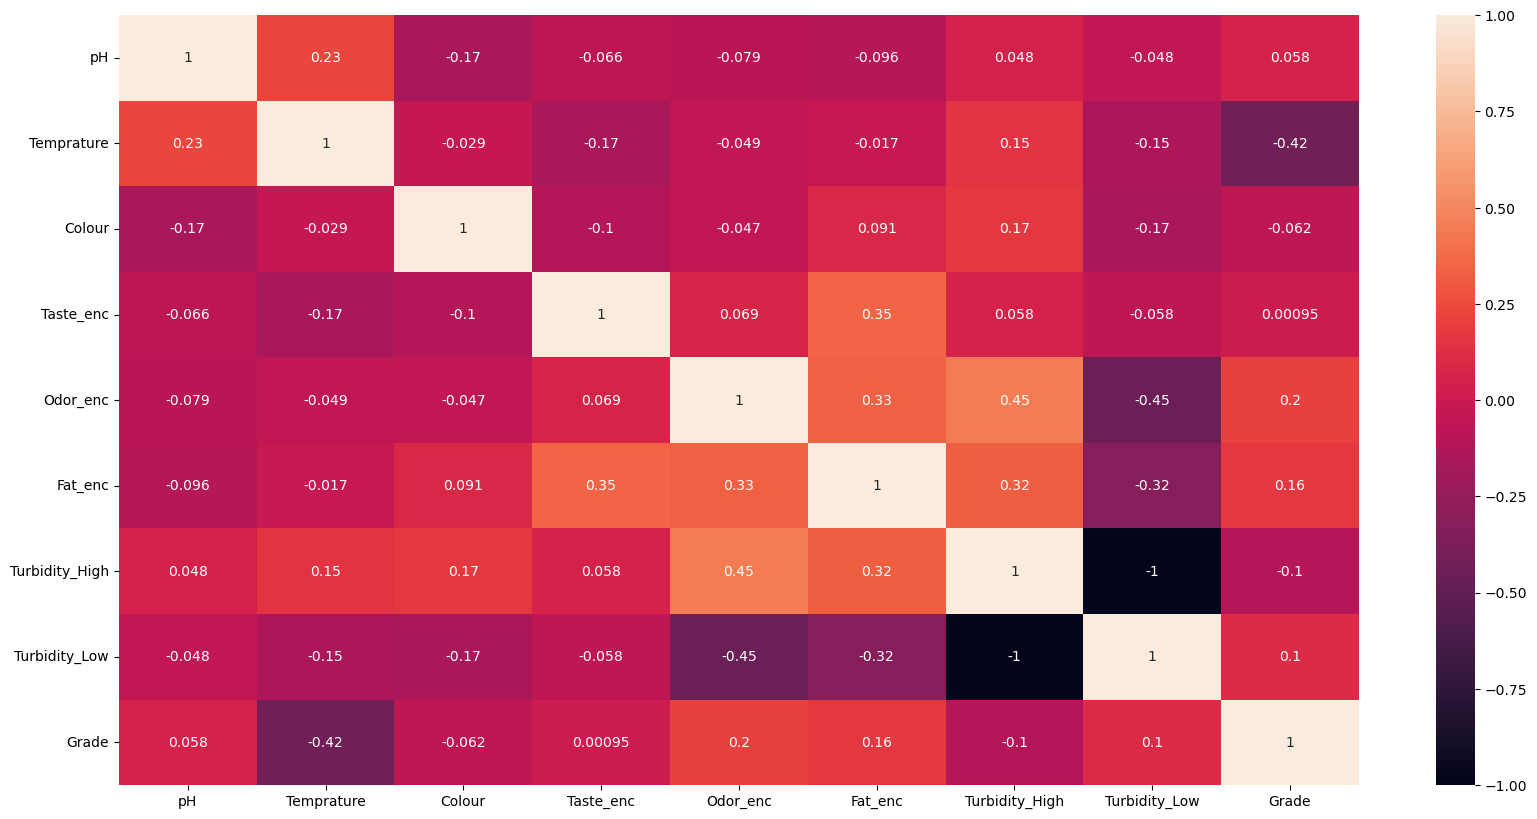

In [36]:
fig,ax = plt.subplots(figsize=[20,10])

corr = X_train_eda.corr()

ax = sns.heatmap(corr,annot=True)
plt.show()

Select Temprature, Odor_enc, Fat_enc, TUrbidity

Overall what we did to train data preprocess:
- For Numeric:
1. Outlier Handling
2. Missing value imputer using median
3. Scaling using Minmax Scaler

- For categoric:
1. Missing value handling
2. ordinal encoding for Taste, Odor and Fat
3. OHE for Turbidity

## **Preprocess**

In [37]:
num_pipeline = Pipeline([
        ('outlier', Winsorizer(capping_method='iqr', tail='both', fold=3)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

num_tr = num_pipeline.fit_transform(X_train[['Temprature']])

In [38]:
cat_1_pipeline = Pipeline([
        ('imputer_1', SimpleImputer(strategy='most_frequent')),
        ('ordinal_enc', OrdinalEncoder(categories=[['Bad', 'Good'], ['Low', 'High']])) #odor & fat
    ])

cat_1_tr = cat_1_pipeline.fit_transform(X_train[['Odor', 'Fat']])

In [39]:
cat_2_pipeline = Pipeline([
        ('imputer_2', SimpleImputer(strategy='most_frequent')),
        ('ohe_enc', OneHotEncoder(sparse=False)) #turbidity
    ])

cat_2_tr = cat_2_pipeline.fit_transform(X_train[['Turbidity']])

In [40]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, ['Temprature']),
        ("cat_ord", cat_1_pipeline, ['Odor', 'Fat']),
        ("cat_ohe", cat_2_pipeline, ['Turbidity']),
    ])

train_tr = full_pipeline.fit_transform(X_train)

In [41]:
train_tr

array([[0.1875 , 0.     , 0.     , 0.     , 1.     ],
       [0.1875 , 0.     , 1.     , 1.     , 0.     ],
       [0.1875 , 1.     , 1.     , 1.     , 0.     ],
       ...,
       [0.125  , 0.     , 1.     , 0.     , 1.     ],
       [0.34375, 0.     , 1.     , 1.     , 0.     ],
       [0.1875 , 1.     , 1.     , 1.     , 0.     ]])

In [42]:
train_manual = np.array(X_train_eda[['Temprature', 'Odor_enc', 'Fat_enc', 'Turbidity_High', 'Turbidity_Low']])

np.allclose(train_tr, train_manual)

True

In [43]:
test_tr = full_pipeline.transform(X_test)

## **Modeling**

In this section we will compare the performance between 4 models:
- LogisticReg
- SVC
- DecisionTree Classifier
- RandomFOrest Classifier

In [44]:
logreg = LogisticRegression(random_state=0)
svc = SVC(random_state=0)
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

**logistic regression**

In [45]:
logreg.fit(train_tr, y_train)

lr_train = logreg.predict(train_tr)
lr_test = logreg.predict(test_tr)

print(classification_report(y_train, lr_train))
print(classification_report(y_test, lr_test))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       300
           1       0.72      0.84      0.78       262
           2       0.50      0.47      0.49       179

    accuracy                           0.65       741
   macro avg       0.63      0.63      0.63       741
weighted avg       0.64      0.65      0.64       741

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       129
           1       0.72      0.93      0.81       112
           2       0.48      0.38      0.42        77

    accuracy                           0.69       318
   macro avg       0.65      0.65      0.65       318
weighted avg       0.67      0.69      0.67       318



In [46]:
# cross-val
logreg_pipe = Pipeline([
        ('preprocess', full_pipeline),
        ('model', LogisticRegression(random_state=0))
    ])
scores = cross_val_score(logreg_pipe, X_train, y_train,
                         scoring="accuracy", cv=10)
print(scores)
print(scores.mean())

[0.64       0.66216216 0.59459459 0.59459459 0.66216216 0.71621622
 0.64864865 0.62162162 0.7027027  0.60810811]
0.6450810810810811


**svc**

In [47]:
svc.fit(train_tr, y_train)

svc_train = svc.predict(train_tr)
svc_test = svc.predict(test_tr)

print(classification_report(y_train, svc_train))
print(classification_report(y_test, svc_test))

              precision    recall  f1-score   support

           0       0.96      0.62      0.75       300
           1       0.78      0.94      0.85       262
           2       0.61      0.79      0.69       179

    accuracy                           0.78       741
   macro avg       0.79      0.79      0.77       741
weighted avg       0.81      0.78      0.77       741

              precision    recall  f1-score   support

           0       0.95      0.70      0.80       129
           1       0.75      0.96      0.84       112
           2       0.60      0.64      0.62        77

    accuracy                           0.77       318
   macro avg       0.77      0.76      0.76       318
weighted avg       0.80      0.77      0.77       318



**decision tree classifier**

In [48]:
dtc.fit(train_tr, y_train)

dtc_train = dtc.predict(train_tr)
dtc_test = dtc.predict(test_tr)

print(classification_report(y_train, dtc_train))
print(classification_report(y_test, dtc_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       300
           1       0.85      0.98      0.91       262
           2       0.91      0.72      0.80       179

    accuracy                           0.89       741
   macro avg       0.89      0.87      0.87       741
weighted avg       0.89      0.89      0.88       741

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       129
           1       0.81      0.97      0.89       112
           2       0.84      0.64      0.73        77

    accuracy                           0.86       318
   macro avg       0.86      0.84      0.84       318
weighted avg       0.86      0.86      0.86       318



**random forest**

In [49]:
rfc.fit(train_tr, y_train)

rfc_train = rfc.predict(train_tr)
rfc_test = rfc.predict(test_tr)

print(classification_report(y_train, rfc_train))
print(classification_report(y_test, rfc_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       300
           1       0.85      0.98      0.91       262
           2       0.91      0.72      0.80       179

    accuracy                           0.89       741
   macro avg       0.89      0.87      0.87       741
weighted avg       0.89      0.89      0.88       741

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       129
           1       0.81      0.97      0.89       112
           2       0.84      0.64      0.73        77

    accuracy                           0.86       318
   macro avg       0.86      0.84      0.84       318
weighted avg       0.86      0.86      0.86       318



In [50]:
# cross-val
rfc_pipe = Pipeline([
        ('preprocess', full_pipeline),
        ('model', RandomForestClassifier(random_state=0))
    ])
scores = cross_val_score(rfc_pipe, X_train, y_train,
                         scoring="accuracy", cv=10)
print(scores)
print(scores.mean())

[0.85333333 0.85135135 0.86486486 0.86486486 0.87837838 0.89189189
 0.87837838 0.86486486 0.87837838 0.90540541]
0.8731711711711713


**Hyper-param Tuning**

In [51]:
# pipeline preprocess + model
rfc_pipe = Pipeline([
        ('preprocess', full_pipeline),
        ('model', RandomForestClassifier(random_state=0))
    ])

# hyperparameter tuning combination
params = [
    {'model__n_estimators': [50, 70, 90],           # 3
     'model__max_features': [2, 3],                 # 2
     'model__max_depth': [3, 5, 7, 9, 12, None],    # 6
     'model__criterion': ['gini', 'entropy']},      # 2   Total 3*2*6*2 = 72 combinations
  ]

grid_search = GridSearchCV(rfc_pipe, params, cv=5,
                           scoring='accuracy',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('outlier',
                                                                                          Winsorizer(capping_method='iqr',
                                                                                                     tail='both')),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Temprature']),
                                                                        ('cat_ord',
                                                                         Pipeline(steps=[('imputer_1',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal_...
                                                                         Pipeline(steps=[('imputer_2',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe_enc',
                                                                                          OneHotEncoder(sparse=False))]),
                                                                         ['Turbidity'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=0))]),
             param_grid=[{'model__criterion': ['gini', 'entropy'],
                          'model__max_depth': [3, 5, 7, 9, 12, None],
                          'model__max_features': [2, 3],
                          'model__n_estimators': [50, 70, 90]}],
             return_train_score=True, scoring='accuracy')

In [52]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__max_features,param_model__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.027751,0.001063,0.004761,0.000157,gini,3,2,50,"{'model__criterion': 'gini', 'model__max_depth...",0.765101,...,0.780047,0.024939,61,0.802365,0.784148,0.792580,0.790894,0.775717,0.789141,0.008887
1,0.035601,0.000141,0.005205,0.000082,gini,3,2,70,"{'model__criterion': 'gini', 'model__max_depth...",0.765101,...,0.780047,0.024939,61,0.802365,0.784148,0.792580,0.790894,0.775717,0.789141,0.008887
2,0.043753,0.000094,0.005690,0.000048,gini,3,2,90,"{'model__criterion': 'gini', 'model__max_depth...",0.765101,...,0.773290,0.018277,68,0.802365,0.784148,0.774030,0.770658,0.775717,0.781384,0.011394
3,0.027532,0.000173,0.004529,0.000030,gini,3,3,50,"{'model__criterion': 'gini', 'model__max_depth...",0.738255,...,0.749002,0.040305,72,0.792230,0.768971,0.772344,0.794266,0.760540,0.777670,0.013303
4,0.036009,0.000306,0.005190,0.000106,gini,3,3,70,"{'model__criterion': 'gini', 'model__max_depth...",0.738255,...,0.761165,0.024431,70,0.792230,0.784148,0.774030,0.794266,0.760540,0.781043,0.012484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.037190,0.000303,0.005247,0.000031,entropy,None,2,70,"{'model__criterion': 'entropy', 'model__max_de...",0.859060,...,0.865055,0.020435,3,0.890203,0.885329,0.883642,0.890388,0.881956,0.886304,0.003430
68,0.045973,0.000293,0.005999,0.000043,entropy,None,2,90,"{'model__criterion': 'entropy', 'model__max_de...",0.859060,...,0.865055,0.020435,3,0.890203,0.885329,0.883642,0.890388,0.881956,0.886304,0.003430
69,0.028684,0.000096,0.004656,0.000033,entropy,None,3,50,"{'model__criterion': 'entropy', 'model__max_de...",0.859060,...,0.863704,0.019720,18,0.890203,0.885329,0.883642,0.890388,0.881956,0.886304,0.003430
70,0.037568,0.000262,0.005267,0.000072,entropy,None,3,70,"{'model__criterion': 'entropy', 'model__max_de...",0.859060,...,0.863704,0.019720,18,0.890203,0.885329,0.883642,0.890388,0.881956,0.886304,0.003430


In [53]:
grid_search.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 7,
 'model__max_features': 2,
 'model__n_estimators': 90}

In [54]:
grid_search.best_score_

0.8704607291855615

In [55]:
model = grid_search.best_estimator_

model.fit(X_train, y_train)

model_train = model.predict(X_train)
model_test = model.predict(X_test)

print(classification_report(y_train, model_train))
print(classification_report(y_test, model_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       300
           1       0.85      0.98      0.91       262
           2       0.91      0.72      0.80       179

    accuracy                           0.89       741
   macro avg       0.89      0.87      0.87       741
weighted avg       0.89      0.89      0.88       741

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       129
           1       0.81      0.97      0.89       112
           2       0.84      0.64      0.73        77

    accuracy                           0.86       318
   macro avg       0.86      0.84      0.84       318
weighted avg       0.86      0.86      0.86       318



**combine pipeline: preprocess + model**

In [56]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('outlier',
                                                  Winsorizer(capping_method='iqr',
                                                             tail='both')),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Temprature']),
                                ('cat_ord',
                                 Pipeline(steps=[('imputer_1',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal_enc',
                                                  OrdinalEncoder(categories=[['Bad',
                                                                              'Good'],
                                                                             ['Low',
                                                                              'High']]))]),
                                 ['Odor', 'Fat']),
                                ('cat_ohe',
                                 Pipeline(steps=[('imputer_2',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe_enc',
                                                  OneHotEncoder(sparse=False))]),
                                 ['Turbidity'])])

In [57]:
X_train

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
143,3.0,40,Good,Bad,Low,Low,255.0
576,6.6,40,Good,Bad,High,High,255.0
686,3.0,40,Good,Good,High,High,255.0
544,6.5,37,Bad,Bad,Low,Low,255.0
889,6.8,45,Good,Good,High,High,245.0
...,...,...,...,...,...,...,...
440,6.6,45,Bad,Bad,Low,High,250.0
840,6.5,36,Bad,Bad,High,Low,255.0
429,6.7,38,Good,Bad,High,Low,255.0
462,5.5,45,Good,Bad,High,High,250.0


In [58]:
# persiapan save model
all_process = Pipeline([
    ("preprocess", full_pipeline),
    ("classification", RandomForestClassifier(max_depth=7, max_features=2, n_estimators=90,
                       random_state=0))
])

all_process.fit(X_train, y_train)
hasil = all_process.predict(X_test)

print(classification_report(y_test, hasil))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       129
           1       0.81      0.97      0.89       112
           2       0.84      0.64      0.73        77

    accuracy                           0.86       318
   macro avg       0.86      0.84      0.84       318
weighted avg       0.86      0.86      0.86       318



In [59]:
# save model
# ensure that your model fitted before saved
import pickle

pickle.dump(all_process, open('milk_pred.pkl', 'wb'))

## MODEL INFERENCE

In [60]:
# Step 1 - Import dependecies
model = pickle.load(open('milk_pred.pkl', 'rb'))

In [61]:
X_train.sample(1).values

array([[6.5, 37, 'Bad', 'Bad', 'Low', 'Low', 245.0]], dtype=object)

In [62]:
# Step 2 - Input New Data
# Create in DataFrame format
new = pd.DataFrame(data=[[6.7, 55, 'Good', 'Good', 'Low', 'High', 240.0]],
                   columns=X_train.columns)
new

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
0,6.7,55,Good,Good,Low,High,240.0


In [63]:
# Step 3 - Send data into pipeline
# preprocess and predict
result = model.predict(new)
result

array([0])

In [64]:
# Step 4 - Result interpretation
if result[0] == 0:
    print('Low')
elif result[0] == 1:
    print('Medium')
else:
    print('High')

Low


----------------------------
----------------------------

In [65]:
df[df['Grade']==2].sample(3)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
655,6.7,38,Good,Bad,High,Low,255.0,2
167,6.8,45,Bad,Good,High,High,255.0,2
508,6.8,40,Good,Good,High,High,255.0,2


In [66]:
import sklearn
sklearn.__version__

'1.1.1'

In [67]:
import feature_engine
feature_engine.__version__

'1.5.2'